In [1]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
import math
from pathlib import Path
import json
from copy import deepcopy
from dataclasses import dataclass
from types import SimpleNamespace

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from autocatalytic_cores_lib import *
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import newton_krylov
from scipy.optimize import broyden1
from scipy.optimize import anderson
from scipy.optimize._nonlin import NoConvergence
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals
from numpy.linalg import svd
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
from scipy.sparse import bmat
from scipy.sparse.csgraph import connected_components
from scipy.linalg import eigh
from scipy.optimize import fsolve
from textwrap import dedent
import networkx as nx   
from matplotlib import animation

In [2]:
class Neumann(object):

    """
    This class describes the Generalized von Neumann growth model as it was
    discussed in Kemeny et al. (1956, ECTA) and Gale (1960, Chapter 9.5):

    Let:
    n ... number of goods
    m ... number of activities
    A ... input matrix is m-by-n
        a_{i,j} - amount of good j consumed by activity i
    B ... output matrix is m-by-n
        b_{i,j} - amount of good j produced by activity i

    x ... intensity vector (m-vector) with non-negative entries
        x'B - the vector of goods produced
        x'A - the vector of goods consumed
    p ... price vector (n-vector) with non-negative entries
        Bp - the revenue vector for every activity
        Ap - the cost of each activity

    Both A and B have non-negative entries. Moreover, we assume that
    (1) Assumption I (every good which is consumed is also produced):
        for all j, b_{.,j} > 0, i.e. at least one entry is strictly positive
    (2) Assumption II (no free lunch):
        for all i, a_{i,.} > 0, i.e. at least one entry is strictly positive

    Parameters
    ----------
    A : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x n`
    B : array_like or scalar(float)
        Part of the state transition equation.  It should be `n x k`
    """

    def __init__(self, A, B):

        self.A, self.B = list(map(self.convert, (A, B)))
        self.m, self.n = self.A.shape

        # Check if (A, B) satisfy the basic assumptions
        assert self.A.shape == self.B.shape, 'The input and output matrices \
              must have the same dimensions!'
        assert (self.A >= 0).all() and (self.B >= 0).all(), 'The input and \
              output matrices must have only non-negative entries!'

        # (1) Check whether Assumption I is satisfied:
        if (np.sum(B, 0) <= 0).any():
            self.AI = False
        else:
            self.AI = True

        # (2) Check whether Assumption II is satisfied:
        if (np.sum(A, 1) <= 0).any():
            self.AII = False
        else:
            self.AII = True

    def __repr__(self):
        return self.__str__()

    def __str__(self):

        me = """
        Generalized von Neumann expanding model:
          - number of goods          : {n}
          - number of activities     : {m}

        Assumptions:
          - AI:  every column of B has a positive entry    : {AI}
          - AII: every row of A has a positive entry       : {AII}

        """
        # Irreducible                                       : {irr}
        return dedent(me.format(n=self.n, m=self.m,
                                AI=self.AI, AII=self.AII))

    def convert(self, x):
        """
        Convert array_like objects (lists of lists, floats, etc.) into
        well-formed 2D NumPy arrays
        """
        return np.atleast_2d(np.asarray(x))


    def bounds(self):
        """
        Calculate the trivial upper and lower bounds for alpha (expansion rate)
        and beta (interest factor). See the proof of Theorem 9.8 in Gale (1960)
        """

        n, m = self.n, self.m
        A, B = self.A, self.B

        f = lambda α: ((B - α * A) @ np.ones((n, 1))).max()
        g = lambda β: (np.ones((1, m)) @ (B - β * A)).min()

        UB = fsolve(f, 1).item()  # Upper bound for α, β
        LB = fsolve(g, 2).item()  # Lower bound for α, β

        return LB, UB


    def zerosum(self, γ, dual=False):
        """
        Given gamma, calculate the value and optimal strategies of a
        two-player zero-sum game given by the matrix

                M(gamma) = B - gamma * A

        Row player maximizing, column player minimizing

        Zero-sum game as an LP (primal --> α)

            max (0', 1) @ (x', v)
            subject to
            [-M', ones(n, 1)] @ (x', v)' <= 0
            (x', v) @ (ones(m, 1), 0) = 1
            (x', v) >= (0', -inf)

        Zero-sum game as an LP (dual --> beta)

            min (0', 1) @ (p', u)
            subject to
            [M, -ones(m, 1)] @ (p', u)' <= 0
            (p', u) @ (ones(n, 1), 0) = 1
            (p', u) >= (0', -inf)

        Outputs:
        --------
        value: scalar
            value of the zero-sum game

        strategy: vector
            if dual = False, it is the intensity vector,
            if dual = True, it is the price vector
        """

        A, B, n, m = self.A, self.B, self.n, self.m
        M = B - γ * A

        if dual == False:
            # Solve the primal LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(m), -1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(m * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([-M.T, np.ones((n, 1))])
            b_iq = np.zeros((n, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(m), 0]).reshape(1, m + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        else:
            # Solve the dual LP (for details see the description)
            # (1) Define the problem for v as a maximization (linprog minimizes)
            c = np.hstack([np.zeros(n), 1])

            # (2) Add constraints :
            # ... non-negativity constraints
            bounds = tuple(n * [(0, None)] + [(None, None)])
            # ... inequality constraints
            A_iq = np.hstack([M, -np.ones((m, 1))])
            b_iq = np.zeros((m, 1))
            # ... normalization
            A_eq = np.hstack([np.ones(n), 0]).reshape(1, n + 1)
            b_eq = 1

            res = linprog(c, A_ub=A_iq, b_ub=b_iq, A_eq=A_eq, b_eq=b_eq,
                          bounds=bounds)

        if res.status != 0 or res.x is None:
            # LP infeasible or error
            return np.nan, None

        # Pull out the required quantities
        value = res.x[-1]
        strategy = res.x[:-1]

        return value, strategy


    def expansion(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given γ (= α or β), the matrix "M = B - γ * A"
        defines a two-player zero-sum game, where the optimal strategies are
        the (normalized) intensity and price vector.

        Outputs:
        --------
        alpha: scalar
            optimal expansion rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):

            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=False)
            V = ZS[0]     # value of the game with γ

            if V >= 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                x = self.zerosum(γ=γ)[1]
                p = self.zerosum(γ=γ, dual=True)[1]
                break

        return γ, x, p

    def interest(self, tol=1e-8, maxit=1000):
        """
        The algorithm used here is described in Hamburger-Thompson-Weil
        (1967, ECTA). It is based on a simple bisection argument and utilizes
        the idea that for a given gamma (= alpha or beta),
        the matrix "M = B - γ * A" defines a two-player zero-sum game,
        where the optimal strategies are the (normalized) intensity and price
        vector

        Outputs:
        --------
        beta: scalar
            optimal interest rate
        """

        LB, UB = self.bounds()

        for iter in range(maxit):
            γ = (LB + UB) / 2
            ZS = self.zerosum(γ=γ, dual=True)
            V = ZS[0]

            if V > 0:
                LB = γ
            else:
                UB = γ

            if abs(UB - LB) < tol:
                γ = (UB + LB) / 2
                p = self.zerosum(γ=γ, dual=True)[1]
                x = self.zerosum(γ=γ)[1]
                break

        return γ, x, p

def compute_von_neumann_alpha_beta(S_plus, S_minus, tol=1e-8):
    """
    Compute von Neumann alpha (expansion), beta (interest),
    and the optimal normalized flows for both problems.

    Returns:
    --------
    alpha : Optimal expansion rate.
    beta : Optimal interest rate.
    x_alpha : Optimal intensity vector (normalized flow) for expansion.
    p_alpha : Optimal price vector for expansion.
    x_beta : Optimal intensity vector (normalized flow) for interest.
    p_beta : Optimal price vector for interest.
    """
    
    A = S_minus.T
    B = S_plus.T
    model = Neumann(A, B)

    # alpha
    alpha, x_alpha, p_alpha = model.expansion(tol=tol)

    # beta
    beta, x_beta, p_beta  = model.interest(tol=tol)

    return alpha, beta, x_alpha, p_alpha, x_beta, p_beta

In [3]:
'''
Praful MGF
'''
import algorithm_1 as algo1
import auxiliary_functions as aux
import algorithm_3 as algo3

In [41]:
def Construct_Kinetics(N_Y, N_R, S_plus, S_minus, degradation=False):
    """
      - Initial concentration Y0
      - Generalized Forward Rate constant kf
      - Degradation kd
    """
    Y0 = [random.uniform(1, 100.0) for _ in range(N_Y)]

    kf = np.array([random.uniform(1e-12, 1.0) for _ in range(N_R)])

    kf /= kf.max()
    
    # degradation degradation coefficient
    kd = None
    if degradation:
        kd = 0.01 * np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])

    return np.array(Y0), kf, kd

def make_dydt_rescaled_func(N_Y, N_R, S_minus, S_plus, kf, kd, law = "MA"):
    eps=1e-12
    lambdas = []
        
    # net stoichiometry in the free (Y) part for each reaction l
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[0:, l]) - np.sum(S_minus[0:, l]))

    def dydt_rescaled(t, Y_star_full):
        Ys = Y_star_full[:N_Y]      # normalized Y^*(t)
        Ys = np.clip(Ys, eps, None) 
        Ys /= Ys.sum()
        
        logN = Y_star_full[-1]      # logN(t)

        net_flux = np.zeros(N_R)

        for l in range(N_R):
            # --- forward flux density using Ystar ---
            prodY = 1.0
            for j in range(N_Y):
                p = S_minus[j, l]
                if p>0:
                    prodY *= Ys[j]**p

            if np.sum(S_minus[0:, l])==0:
                v_f = 0.0
            else:
                if law=="MM":
                    Kf = prodY
                    v_f = 0.0 if (kf[l]+Kf)==0 else Kf/(kf[l]+Kf)
                else:
                    v_f = kf[l]*prodY

            net_flux[l] = v_f
            
        lambda_t = float(np.dot(net_flux, netStoich_Y))
        lambdas.append(lambda_t)

        # dY*/dt
        dYs = np.zeros(N_Y)
        for j in range(N_Y):
            row = S_plus[j,:] - S_minus[j,:]
            dYs[j] = float(np.dot(row, net_flux)) - lambda_t*Ys[j]

        # d(logN)/dt = lambda(t)
        return np.concatenate([dYs, [lambda_t]])

    return dydt_rescaled, lambdas
    
def Solve_Scaled_System(S_minus, S_plus, Y0, N_Y, N_R,
                        kf, kd, dt, n_steps, threshold, extra_steps, law = "MA"):
    """
    Fix step dt，simulate n_steps：
      - t_eval      (length = n_steps+1)
      - Ystar_traj  (shape (N_Y, n_steps+1))
      - Yabs_traj   (shape (N_Y, n_steps+1))
      - lambdas     (length = n_steps+1)
      - N_traj      (length = n_steps+1)
    """
    def single_run(Y0, n_steps):
        # initialize N, normalize Y*
        N0 = np.sum(Y0)
        Ystar0 = Y0 / N0
        logN0 = math.log(N0)
        y0 = np.concatenate([Ystar0, [logN0]])
    
        ttot = dt * n_steps
        t_eval = np.linspace(0, ttot, n_steps + 1)
    
        dydt_rescaled, lambdas = make_dydt_rescaled_func(
            N_Y, N_R, S_minus, S_plus, kf, kd, law
        )
    
        sol = solve_ivp(
            fun=lambda t, y: dydt_rescaled(t, y),
            t_span=[0, ttot],
            y0=y0,
            method="LSODA",
            dense_output=False,
            t_eval=t_eval,
            rtol=1e-6,
            atol=1e-8
        )
    
        Ystar_traj = sol.y[:N_Y, :]             # normalize Y^*(t)
        logN_traj = sol.y[N_Y, :]               # logN(t)
        N_traj = np.exp(logN_traj)              # exact N(t)
        Yabs_traj = Ystar_traj * N_traj         # exact Y(t) = N(t)*Y^*(t)
    
        return t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj, dydt_rescaled

    t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj, dydt_rescaled = single_run(Y0, n_steps)

    """
    compute the residual of differencial equation and check if it reach the convergence requirement
    and add additional steps if not
    """
    
    while True:
        # the last time point
        q_final = Ystar_traj[:, -1]
        lambda_final = lambdas[-1]
        logN_final = math.log(N_traj[-1])
        # compute residual dY*/dt
        d_full = dydt_rescaled(0.0, np.concatenate([q_final, [logN_final]]))
        residual = np.max(np.abs(d_full[:N_Y]))
        if residual < threshold:
            break

        # if need to run extra_steps
        Y0_new = Yabs_traj[:, -1]
        t_ext, Ystar_ext, Yabs_ext, lambda_ext, N_ext, _ = single_run(Y0_new, extra_steps)

        # conjugate data
        t_ext_shifted = t_ext[1:] + t_eval[-1]
        t_eval = np.concatenate([t_eval, t_ext_shifted])
        Ystar_traj = np.hstack([Ystar_traj, Ystar_ext[:, 1:]])
        Yabs_traj  = np.hstack([Yabs_traj,  Yabs_ext[:,  1:]])
        lambdas    = lambdas + lambda_ext[1:]
        N_traj     = np.concatenate([N_traj, N_ext[1:]])

    return t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj
    
# =============================================================================
# long-term growth rate
# =============================================================================
def compute_long_term_growth_rate(lambdas):
    """
    Average the last last_n values of the lambda(t) sequence to obtain an estimate of the exponential growth rate λ
    """
    if len(lambdas) == 0:
       return 0.0
    return lambdas[-1]

In [25]:
def solve_steadystate_by_newton_krylov(
    S_plus, S_minus, N_Y, N_R, Y0, kf,
    law='MA',
    dt=1e-3, n_steps=20000,
    tol=1e-7, maxiter=5000, inner_maxiter=200): 
    '''
    Perform time-dependent simulation until t = dt * n_steps, obtaining initial q0, lambda0.
    Solve F(q,λ)=0 using Newton–Krylov, with parameterization ensuring q ∈ simplex.
    '''
    # =============================================================================
    # —— Simulation for some steps to get initial condition for equation —— 
    # =============================================================================
    lambdas = []
    Y0 = np.asarray(Y0, float)
    N0 = Y0.sum()
    Ystar0 = Y0 / N0
    logN0 = np.log(N0)
    y0 = np.concatenate([Ystar0, [logN0]])

    # netStoich
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[0:, l]) - np.sum(S_minus[0:, l]))

    def dydt_rescaled(t, y):
        Ys = y[:N_Y]
        Ys = np.clip(Ys, 1e-12, None)
        Ys /= Ys.sum()
        
        net_flux = np.zeros(N_R)

        for l in range(N_R):
            # --- forward flux density using Ystar ---
            prodY = 1.0
            for j in range(N_Y):
                p = S_minus[j, l]
                if p>0:
                    prodY *= Ys[j]**p

            if np.sum(S_minus[0:, l])==0:
                v_f = 0.0
            else:
                if law=="MM":
                    Kf = prodY
                    v_f = 0.0 if (kf[l]+Kf)==0 else Kf/(kf[l]+Kf)
                else:
                    v_f = kf[l]*prodY

            net_flux[l] = v_f
            
        lambda_t = float(np.dot(net_flux, netStoich_Y))
        lambdas.append(lambda_t)

        # dY*/dt
        dYs = np.zeros(N_Y)
        for j in range(N_Y):
            row = S_plus[j,:] - S_minus[j,:]
            dYs[j] = float(np.dot(row, net_flux)) - lambda_t*Ys[j]

        # d(logN)/dt = lambda(t)
        return np.concatenate([dYs, [lambda_t]])

    ttot = dt * n_steps
    t_eval = np.linspace(0, ttot, n_steps + 1)
    sol = solve_ivp(
        fun=dydt_rescaled,
        t_span=[0, ttot],
        y0=y0,
        method="LSODA",
        t_eval=t_eval,
        rtol=1e-6, atol=1e-8
    )
    Ystar_traj = sol.y[:N_Y, :]
    Ys_final = Ystar_traj[:, -1]

    # initial guess q0, lambda0
    q0 = np.clip(Ys_final, 1e-12, None)
    q0 /= q0.sum()
    J0 = np.array([
        kf[r] * np.prod(q0**S_minus[:, r])
        for r in range(N_R)
    ])
    lam0 = float(netStoich_Y.dot(J0))

    # =============================================================================
    # —— Newton–Krylov solve steady state equation —— 
    #    Parameterization: u_vars ∈ ℝ^(N_Y-1)， λ ∈ ℝ
    # =============================================================================

    # construct residual: x = [u_vars (N_Y-1), λ]
    def residual_mapped(x):
        u_vars = x[:N_Y-1]
        lam = x[N_Y-1]
        # rebuild u_full, set u_N=0
        u_full = np.concatenate([u_vars, [0.0]])
        # use softmax projection to q
        expu = np.exp(u_full - u_full.max())
        q = expu / expu.sum()
        # compute flow
        J = np.array([
            kf[r] * np.prod(q**S_minus[:, r])
            for r in range(N_R)
        ])
        # F(q, λ) = S*J - λ*q
        return (S_plus - S_minus).dot(J) - lam * q

    # initial x0: use q0 project back to u0_vars
    u0_full = np.log(q0)
    # gauge: set u_N = 0, others minus u_N
    u0_vars = u0_full[:-1] - u0_full[-1]
    x0 = np.concatenate([u0_vars, [lam0]])
    
    try:
        sol_nk = newton_krylov(
            residual_mapped,
            x0,
            method='lgmres',
            inner_maxiter=inner_maxiter,
            f_tol=tol,
            maxiter=maxiter,
            line_search=True,
        )
        
    except Exception as e_krylov:
        sol_nk = broyden1(
            residual_mapped,
            x0,
            f_tol=tol,
            maxiter=maxiter
        )
        
    except Exception as e_broyden:
        sol_nk = anderson(
            residual_mapped,
            x0,
            f_tol=tol,
            maxiter=maxiter
        )

    # slove q*, λ*
    u_star_vars = sol_nk[:N_Y-1]
    lam_star   = sol_nk[N_Y-1]
    u_star_full = np.concatenate([u_star_vars, [0.0]])
    expu = np.exp(u_star_full - u_star_full.max())
    q_star = expu / expu.sum()

    # final J_star
    J_star = np.array([
        kf[r] * np.prod(q_star**S_minus[:, r])
        for r in range(N_R)
    ])

    return q_star, lam_star, J_star

In [6]:
def compute_shannon_entropy(Y: np.ndarray, clip_tol: float = 1e-12, eps: float = 1e-10) -> float:
    """
    Given a set of non-negative Y concentrations, 
    first normalize them as p_i = Y_i / sum(Y_i), 
    then calculate the Shannon entropy H = -sum_i p_i * log(p_i). 
    If sum(Y) == 0, return 0.
    eps is used to avoid log(0) or numerical underflow.
    """
    Y = np.asarray(Y, float)

    # Correct minor negative drift or underflow
    Y = np.where(Y < clip_tol, 0.0, Y)

    total = Y.sum()
    if total <= 0:
        return 0.0

    # Normalization
    p = Y / total

    # Filter out values that are too small
    mask = p > eps
    if not np.any(mask):
        return 0.0

    p = p[mask]
    return -np.sum(p * np.log(p))

# Study fixed topology with randomized kinetics, and with infinite norm for stoichiometric bound

In [42]:
# compute the topological growth bound
def compute_topological_growth_bound(S_minus, alpha, x_alpha):
    x_alpha = x_alpha / np.max(x_alpha)  # Normalize to make max(x_alpha) = 1
    sp = np.dot(S_minus, x_alpha)
    mu = (alpha - 1) * sp.sum()
    return mu

def compute_Sx(S_plus, S_minus, x_alpha):
    x_alpha = x_alpha / np.sum(x_alpha)
    Stot = S_plus - S_minus
    sp = np.dot(Stot, x_alpha)
    return sp

In [34]:
def study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations, dt, n_steps):

    lambda_list = []
    H_list = []

    alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus, S_minus)
    mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
    
    for i in range(n_realizations):
        # construct random kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_Y, N_R, S_plus, S_minus, degradation=False
        )

        '''
        here the problem is construct random kinetics might be hard to sample the whole kinetic space for large networks,
        the idea to solve is sampling the space with a fixed step size, but also too bothering and low-efficient
        '''
        
        try:
            q_star, lambda_long, J_star = solve_steadystate_by_newton_krylov(
                    S_plus, S_minus, N_Y, N_R, Y0, kf)
            comp_vec = q_star 
            
        except NoConvergence:        
            threshold = 1e-4
            extra_steps = 100000
            t_eval, Ystar_traj, Yabs_traj, lambdas, N_traj = Solve_Scaled_System(
                S_minus, S_plus, Y0, N_Y, N_R,
                kf, kd, dt, n_steps, threshold, extra_steps, law = "MA")
            
            lambda_long = compute_long_term_growth_rate(lambdas)
            comp_vec = Ystar_traj[:, -1]

        # use last composition vector compute Shannon entropy
        H = compute_shannon_entropy(comp_vec)

        # check if finite
        if np.isfinite(lambda_long) and np.isfinite(H):
            lambda_list.append(lambda_long)
            H_list.append(H)

    # λ KDE curve 
    lambda_arr = np.array(lambda_list)
    kde = gaussian_kde(lambda_arr)
    x_vals = np.linspace(lambda_arr.min(), lambda_arr.max(), 300)
    density = kde(x_vals)
    
    topo_bound = mu

    plt.figure(figsize=(7,5))
    plt.plot(x_vals, density, lw=2)
    plt.fill_between(x_vals, density, alpha=0.3)

    plt.axvline(topo_bound, ls='--', color='red', lw=1.5, label=f'μ_bound = {topo_bound:.3f}')

    ymax = density.max()
    plt.text(topo_bound, ymax*0.9, f'μ = {topo_bound:.3f}',
            color='red', fontsize=10, ha='center', va='bottom')

    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Density of λ over {len(lambda_arr)} simulations", fontsize=14)
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # H vs λ 
    plt.figure(figsize=(6,5))
    plt.scatter(lambda_list, H_list, s=30, edgecolors='k', alpha=0.7)
    plt.axvline(topo_bound, ls='--', color='red', lw=1.5, label=f'μ_bound = {topo_bound:.3f}')
    
    H_max = max(H_list)
    plt.text(topo_bound, H_max*0.9, f'μ = {topo_bound:.3f}',
             color='red', fontsize=10, ha='center', va='bottom')
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Shannon entropy H", fontsize=12)
    plt.title("Species distribution at steady-state vs λ", fontsize=14)
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return lambda_list, H_list

In [9]:
'''
Motif 1 shrinking
'''
S_tot = np.array([
    [1,-2],
    [-1,1]
])

S_plus = np.array([
    [1,0],
    [0,1]
])

S_minus = np.array([
    [0,2],
    [1,0]
])

N_Y = 2
N_R = 2

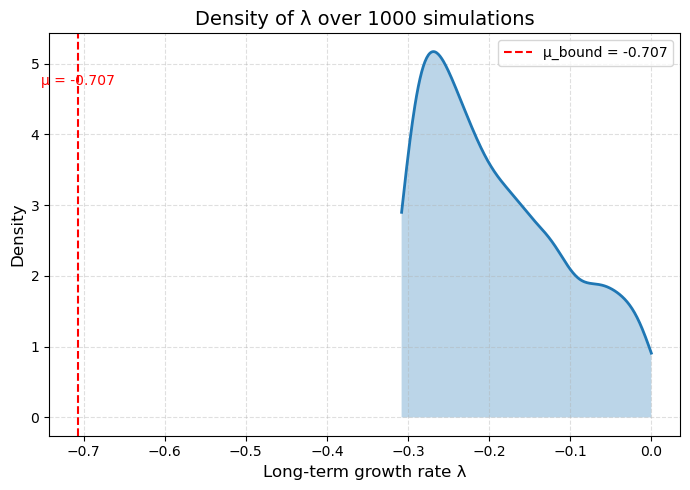

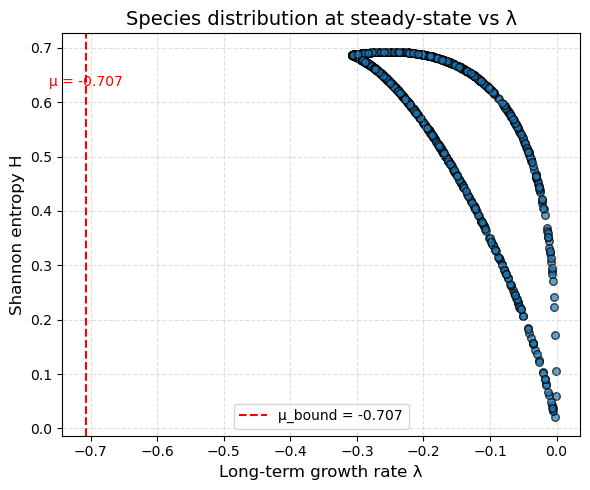

In [17]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
        n_realizations=1000,
        dt=1e-3,
        n_steps=100000)

In [18]:
'''
Motif 1 growing
'''
S_tot2 = np.array([
    [1,-1],
    [-1,2]
])

S_plus2 = np.array([

    [1,0],
    [0,2]
])

S_minus2 = np.array([
    [0,1],
    [1,0]
])

N_Y2 = 2
N_R2 = 2

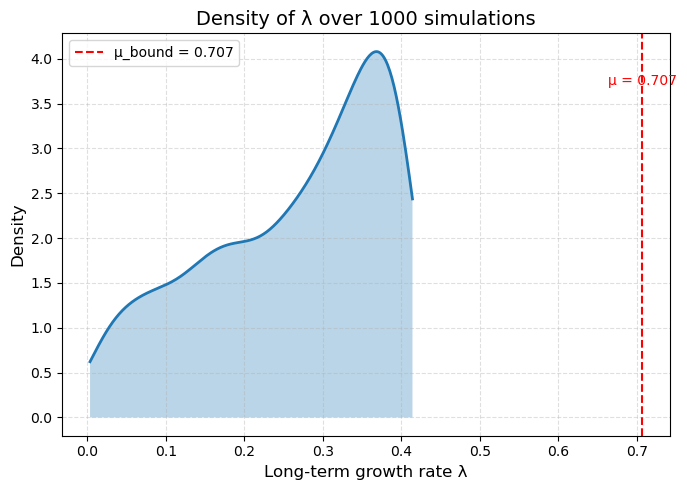

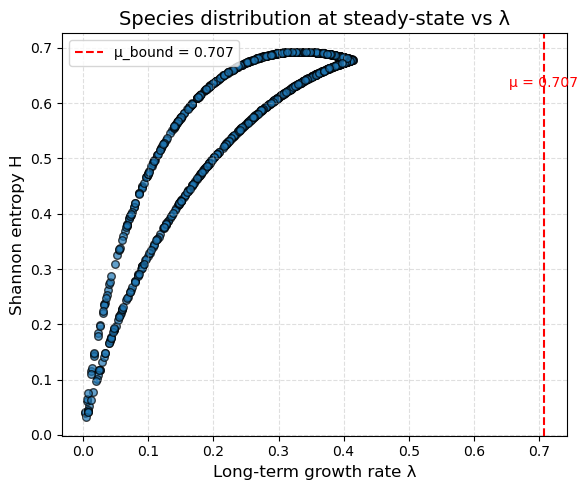

In [19]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus2, S_minus2, N_Y2, N_R2,
        n_realizations=1000,
        dt=1e-3,
        n_steps=100000)

In [20]:
'''
Type 2:
'''

S_tot2 = np.array([[-1, 0, 2],
              [1, -1, 0],
              [0, 1, -1]])

S_minus2 = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

S_plus2 = np.array([[0, 0, 2],
              [1, 0, 0],
              [0, 1, 0]])

N_Y2 = 3
N_R2 = 3

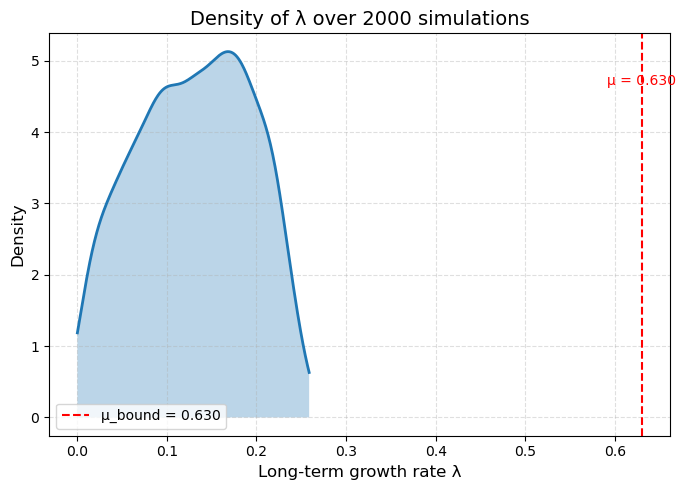

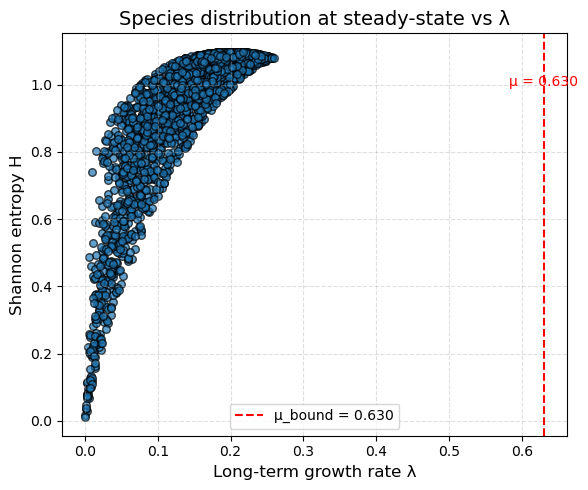

In [21]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus2, S_minus2, N_Y2, N_R2,
        n_realizations=2000,
        dt=1e-3,
        n_steps=100000)

In [23]:
'''
Type 3
'''
S_tot3 = np.array([[-1, 1, 1],
               [1, -1, 0],
               [1, 0, -1]])

S_minus3 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_plus3 = np.array([[0, 1, 1],
               [1, 0, 0],
               [1, 0, 0]])
N_Y3 = 3
N_R3 = 3

D:\Anaconda\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))


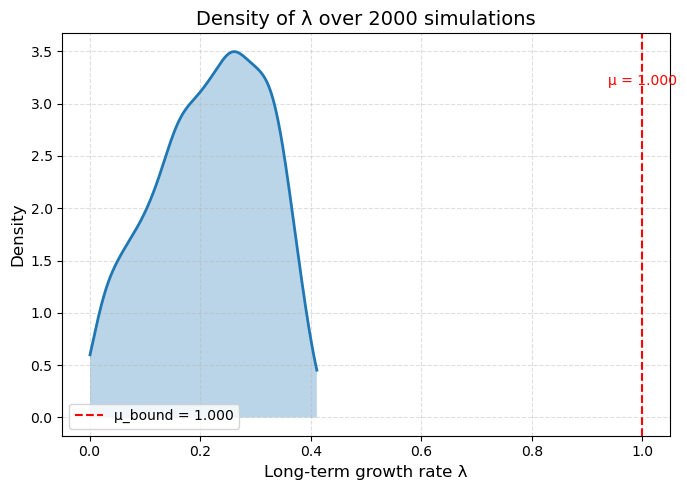

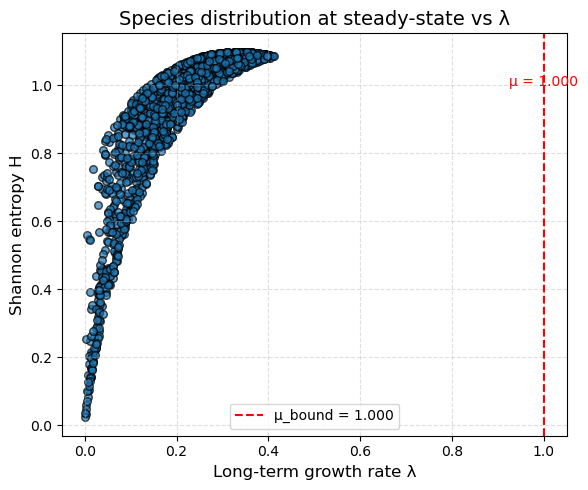

In [26]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus3, S_minus3, N_Y3, N_R3,
        n_realizations=2000,
        dt=1e-3,
        n_steps=100000)

In [27]:
'''
Type 4
'''

S_tot4 = np.array([[-1, 1, 1],
               [1, -1, 0],
               [1, 1, -1]])

S_minus4 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_plus4 = np.array([[0, 1, 1],
               [1, 0, 0],
               [1, 1, 0]]) 
N_Y4 = 3
N_R4 = 3

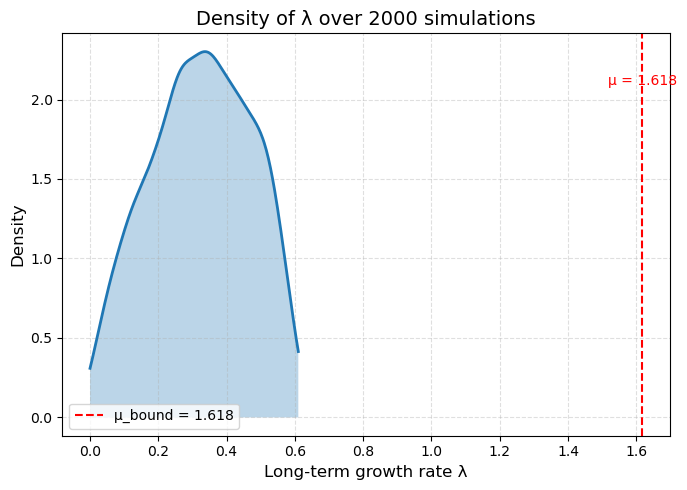

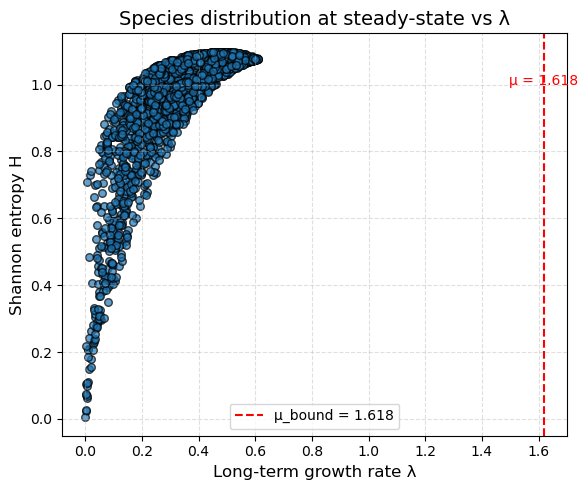

In [28]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus4, S_minus4, N_Y4, N_R4,
        n_realizations=2000,
        dt=1e-3,
        n_steps=100000)

In [30]:
'''
Type 5 growing
'''
N_Y5 = 3
N_R5 = 3

S_tot5 = np.array([[-1, 1, 1],
               [1, -1, 1],
               [1, 1, -1]])

S_minus5 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_plus5 = np.array([[0, 1, 1],
               [1, 0, 1],
               [1, 1, 0]])

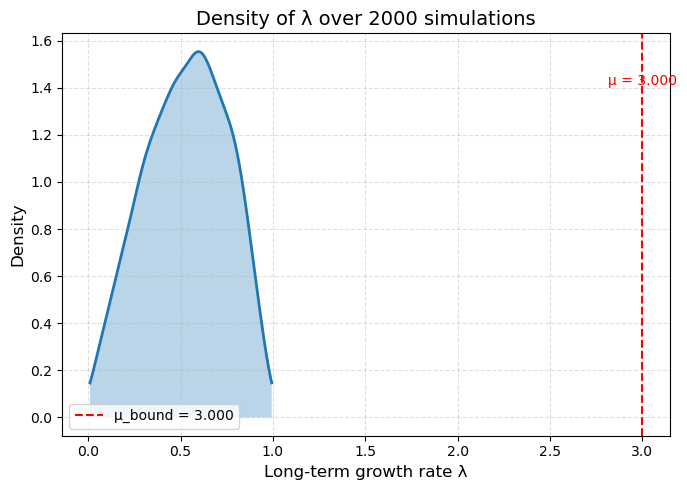

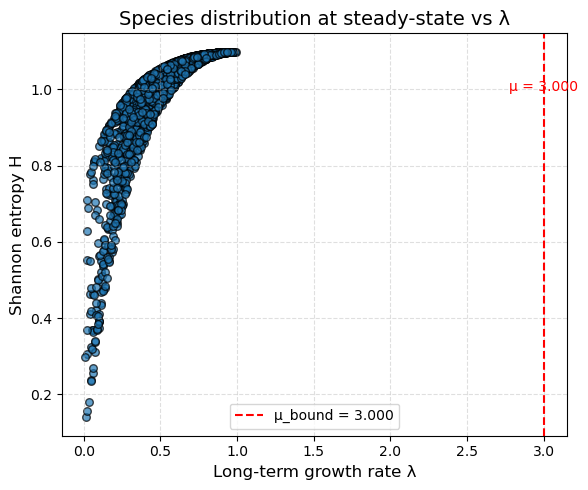

In [31]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus5, S_minus5, N_Y5, N_R5,
        n_realizations=2000,
        dt=1e-3,
        n_steps=100000)

In [35]:
'''
Type 5 shrinking
'''
N_Y5 = 3
N_R5 = 3

S_tot5 = np.array([[1, -1, -1],
               [-1, 1, -1],
               [-1, -1, 1]])

S_plus5 = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_minus5 = np.array([[0, 1, 1],
               [1, 0, 1],
               [1, 1, 0]])

In [43]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus5, S_minus5, N_Y5, N_R5,
        n_realizations=2000,
        dt=1e-4,
        n_steps=1000000)

KeyboardInterrupt: 

# What if we have normalized steady state flux and normalized optimal flow with sum(xi) = sum(Ji) = 1

In [47]:
# compute the topological growth bound
def compute_topological_growth_bound(S_minus, alpha, x_alpha):
    x_alpha = x_alpha / np.sum(x_alpha)  # Normalize to make max(x_alpha) = 1
    sp = np.dot(S_minus, x_alpha)
    mu = (alpha - 1) * sp.sum()
    return mu

def compute_Sx(S_plus, S_minus, x_alpha):
    x_alpha = x_alpha / np.sum(x_alpha)
    Stot = S_plus - S_minus
    sp = np.dot(Stot, x_alpha)
    return sp

In [44]:
# =============================================================================
# long-term growth rate
# =============================================================================
def compute_long_term_growth_rate(
    S_minus: np.ndarray,
    S_plus:  np.ndarray,
    *,
    J_norm: np.ndarray = None,
    q_final: np.ndarray = None,
    kf:     np.ndarray = None,
    law:    str       = "MA",
    eps:    float     = 1e-12
) -> float:
    """
    Compute long‐term growth rate λ = sum_i [ (S+ - S-) · J_norm ]_i.

    You can either pass in
      - J_norm : a flux vector (normalized so sum(J_norm)=1), or
      - q_final, kf, law : in which case J_norm is computed from the final
        composition via the mass‐action or MM law.
    """
    Stot = S_plus - S_minus  # shape (N_Y, N_R)

    if J_norm is None:
        # must have q_final and kf
        if q_final is None or kf is None:
            raise ValueError("Either J_norm or (q_final and kf) must be provided.")
        # compute raw forward flux
        N_Y, N_R = S_minus.shape
        Ys = np.clip(q_final, eps, None)
        J = np.zeros(N_R)
        for r in range(N_R):
            sub = S_minus[:, r]
            if sub.sum() == 0:
                J[r] = 0.0
            else:
                prod = np.prod(Ys**sub)
                if law == "MM":
                    J[r] = prod / (kf[r] + prod) if (kf[r] + prod) != 0 else 0.0
                else:
                    J[r] = kf[r] * prod
        total = J.sum()
        if total <= 0:
            return 0.0
        J_norm = J / total

    else:
        # ensure normalization
        total = np.sum(J_norm)
        if abs(total - 1.0) > 1e-6:
            J_norm = J_norm / total

    # now compute λ = sum_i (Stot @ J_norm)_i
    net_prod = Stot.dot(J_norm)   # length N_Y
    return float(net_prod.sum())

In [56]:
def study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations, dt, n_steps):

    lambda_list = []
    H_list = []

    alpha, beta, x_alpha, p_alpha, x_beta, p_beta = compute_von_neumann_alpha_beta(S_plus, S_minus)
    mu = compute_topological_growth_bound(S_minus, alpha, x_alpha)
    
    for i in range(n_realizations):
        # construct random kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_Y, N_R, S_plus, S_minus, degradation=False
        )

        '''
        here the problem is construct random kinetics might be hard to sample the whole kinetic space for large networks,
        the idea to solve is sampling the space with a fixed step size, but also too bothering and low-efficient
        '''

        try:
            q_star, lambda_raw, J_star = solve_steadystate_by_newton_krylov(
                S_plus, S_minus, N_Y, N_R, Y0, kf)
            # Newton–Krylov already returns a *normalized* J_star
            lambda_long = compute_long_term_growth_rate(
                S_minus, S_plus, J_norm=J_star
            )
            comp_vec = q_star 
        
        except NoConvergence:
            threshold = 1e-4
            extra_steps = 10000
            t_eval, Ystar_traj, Yabs_traj, mus, N_traj = Solve_Scaled_System(
                S_minus, S_plus, Y0, N_Y, N_R,
                kf, kd, dt, n_steps, threshold, extra_steps, law = "MA")                                                                            
            comp_vec = Ystar_traj[:, -1]
            # fallback: compute λ by recomputing and normalizing the flux
            lambda_long = compute_long_term_growth_rate(
                S_minus, S_plus,
                q_final=comp_vec,
                kf=kf,
                law="MA"
            )


        # use last composition vector compute Shannon entropy
        H = compute_shannon_entropy(comp_vec)

        # check if finite
        if np.isfinite(lambda_long) and np.isfinite(H):
            lambda_list.append(lambda_long)
            H_list.append(H)

    # λ KDE curve 
    lambda_arr = np.array(lambda_list)
    kde = gaussian_kde(lambda_arr)
    x_vals = np.linspace(lambda_arr.min(), lambda_arr.max(), 300)
    density = kde(x_vals)
    
    topo_bound = mu

    plt.figure(figsize=(7,5))
    plt.plot(x_vals, density, lw=2)
    plt.fill_between(x_vals, density, alpha=0.3)

    plt.axvline(topo_bound, ls='--', color='red', lw=1.5, label=f'μ_bound = {topo_bound:.3f}')

    ymax = density.max()
    plt.text(topo_bound, ymax*0.9, f'μ = {topo_bound:.3f}',
            color='red', fontsize=10, ha='center', va='bottom')

    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Density of λ over {len(lambda_arr)} simulations", fontsize=14)
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # H vs λ 
    plt.figure(figsize=(6,5))
    plt.scatter(lambda_list, H_list, s=30, edgecolors='k', alpha=0.7)
    plt.axvline(topo_bound, ls='--', color='red', lw=1.5, label=f'μ_bound = {topo_bound:.3f}')
    
    H_max = max(H_list)
    plt.text(topo_bound, H_max*0.9, f'μ = {topo_bound:.3f}',
             color='red', fontsize=10, ha='center', va='bottom')
    
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Shannon entropy H", fontsize=12)
    plt.title("Species distribution at steady-state vs λ", fontsize=14)
    plt.legend()
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return lambda_list, H_list

# Type 1

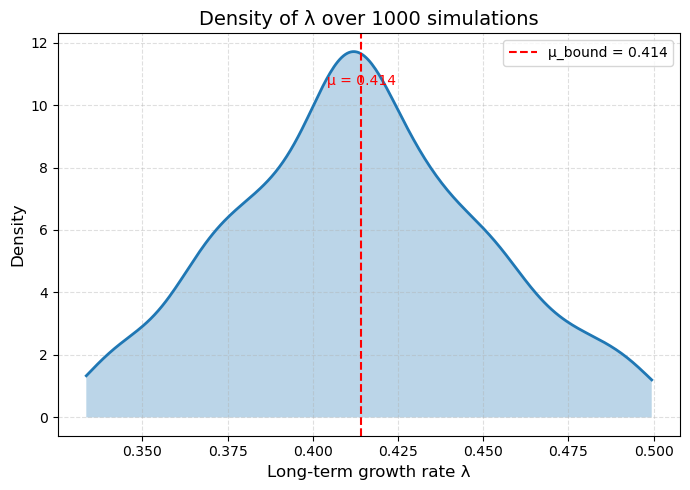

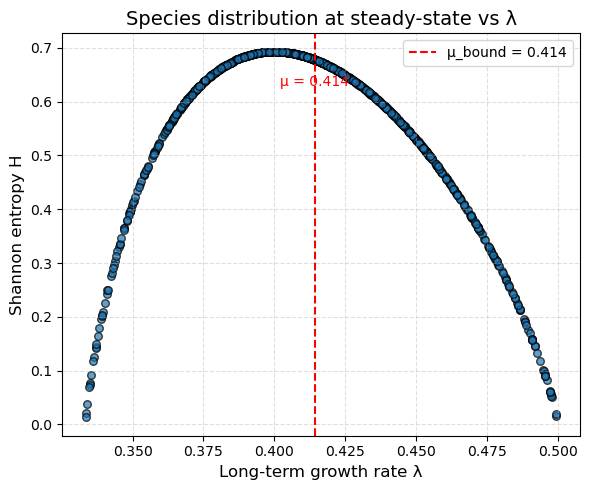

In [48]:
"""
Type 1 growing
"""

N_Y = 2
N_R = 2

S_minus = np.array([
    [1,0],
    [0,1]
])

S_plus = np.array([
    [0,2],
    [1,0]
])

    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=1000, dt = 1e-3, n_steps = 250000)

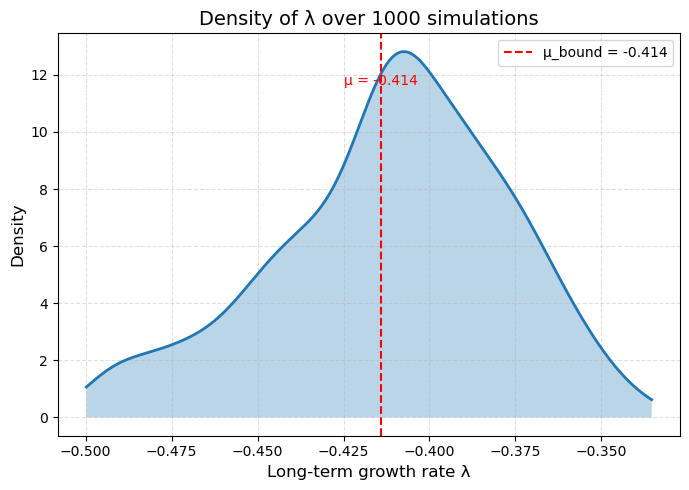

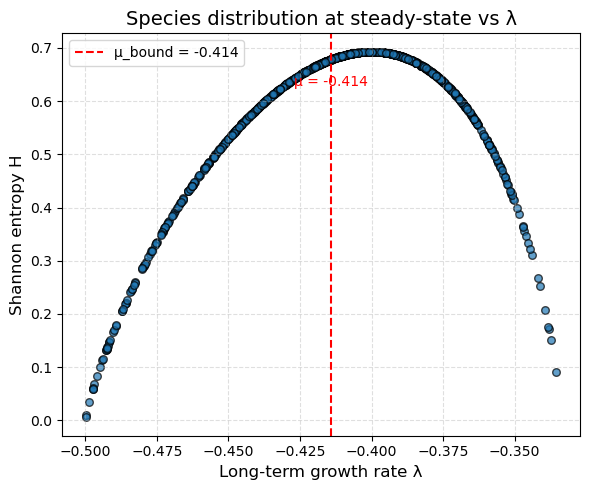

In [49]:
"""
Type 1 shrinking
"""
N_Y = 2
N_R = 2

S_plus = np.array([
    [1,0],
    [0,1]
])

S_minus = np.array([
    [0,2],
    [1,0]
])

    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=1000, dt = 1e-3, n_steps = 250000)

# Type 2

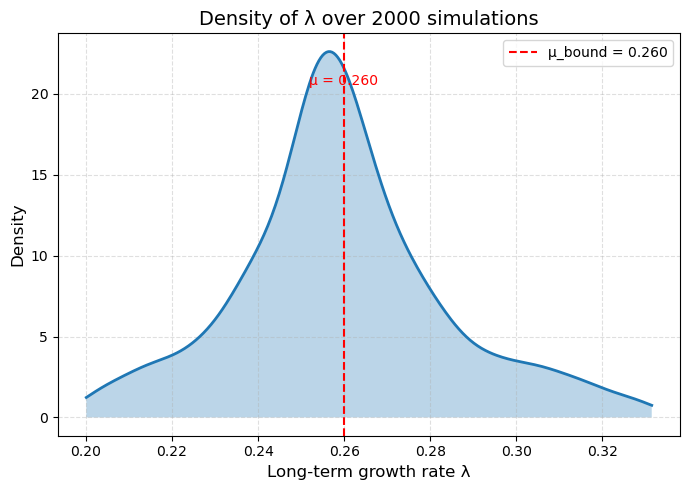

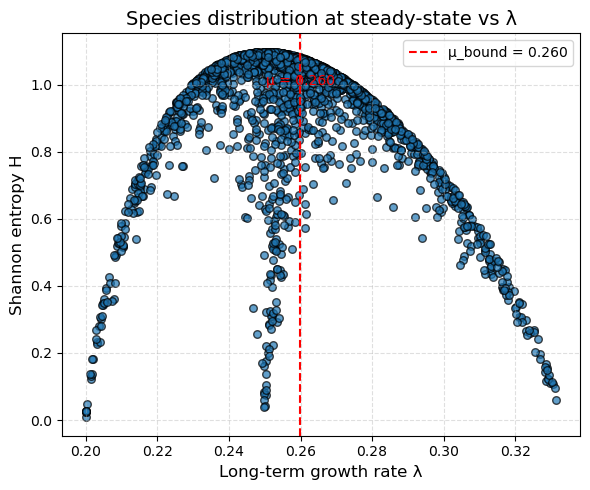

In [50]:
"""
Type 2 growing
"""


S_minus = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

S_plus = np.array([[0, 0, 2],
              [1, 0, 0],
              [0, 1, 0]])

N_Y = 3
N_R = 3
    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-3, n_steps = 250000)

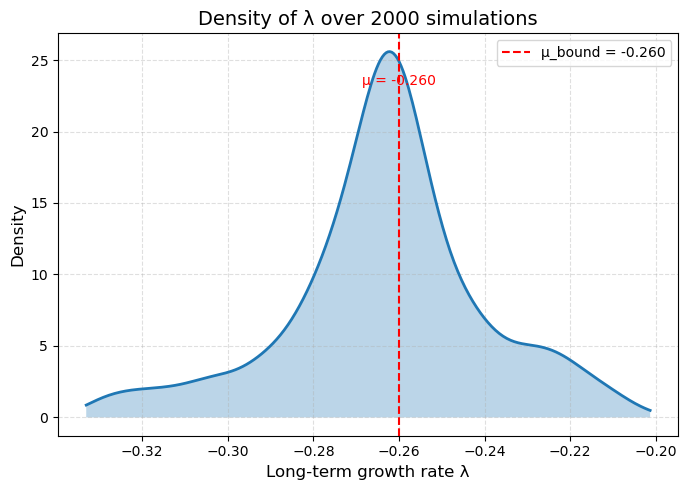

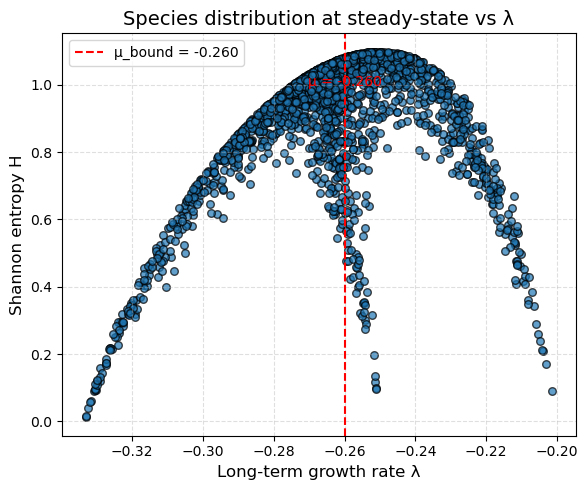

In [51]:
"""
Type 2 shrinking
"""


S_plus = np.array([[1, 0, 0],
              [0, 1, 0],
              [0, 0, 1]])

S_minus = np.array([[0, 0, 2],
              [1, 0, 0],
              [0, 1, 0]])

N_Y = 3
N_R = 3
    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-3, n_steps = 250000)

# Type 3

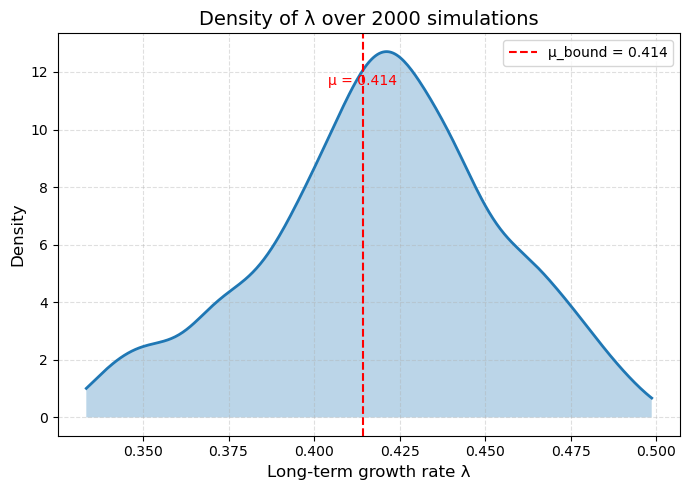

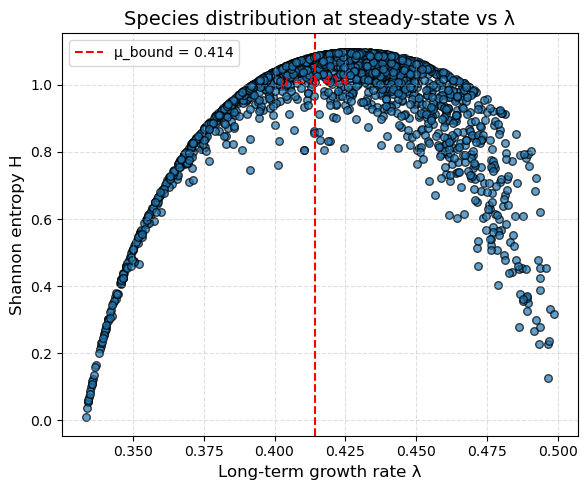

In [52]:
"""
Type 3 growing
"""


S_minus = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_plus = np.array([[0, 1, 1],
               [1, 0, 0],
               [1, 0, 0]])

N_Y = 3
N_R = 3
    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-3, n_steps = 250000)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4504\1475581979.py:51: RuntimeWarning: invalid value encountered in divide
  J_norm = J_norm / total


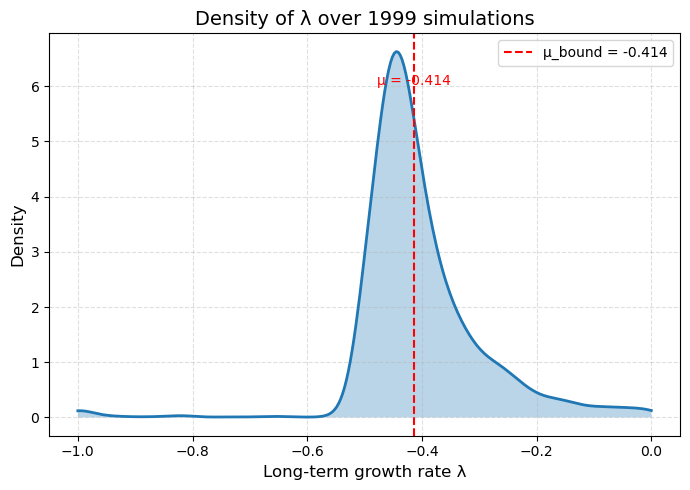

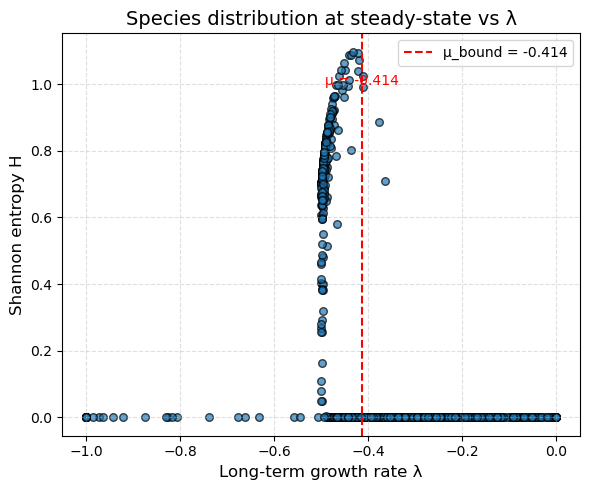

In [53]:
"""
Type 3 shrinking
"""


S_plus = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_minus = np.array([[0, 1, 1],
               [1, 0, 0],
               [1, 0, 0]])

N_Y = 3
N_R = 3
    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-4, n_steps = 2500000)

# Type 4

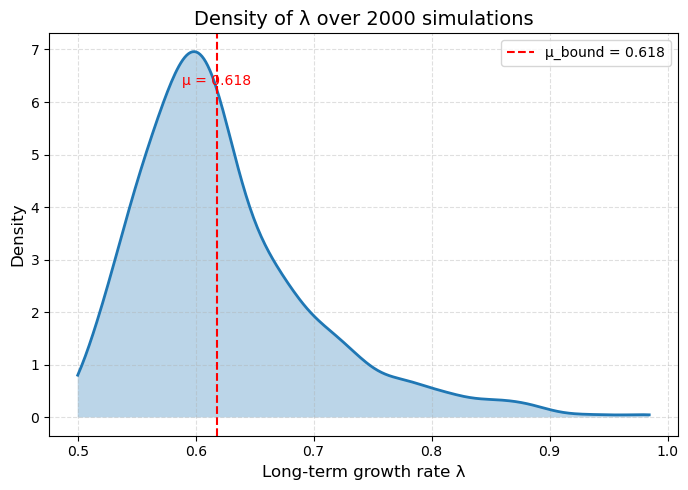

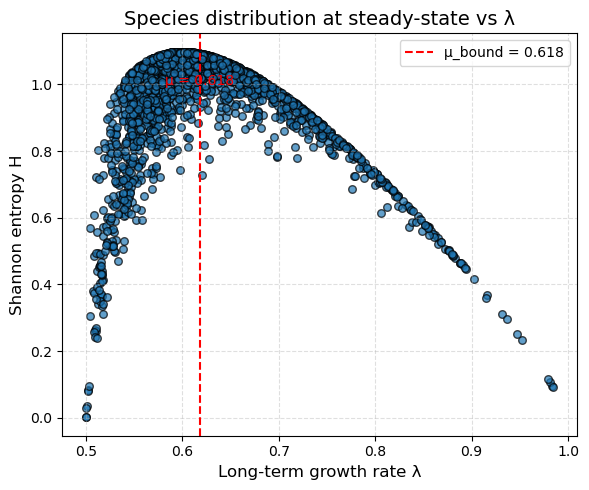

In [54]:
"""
Type 4 growing
"""


S_minus = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_plus = np.array([[0, 1, 1],
               [1, 0, 0],
               [1, 1, 0]])

N_Y = 3
N_R = 3
    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-3, n_steps = 250000)

In [57]:
"""
Type 4 shrinking
"""

S_plus = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_minus = np.array([[0, 1, 1],
               [1, 0, 0],
               [1, 1, 0]])


N_Y = 3
N_R = 3
    
# run
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-4, n_steps = 2500000)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4504\1475581979.py:51: RuntimeWarning: invalid value encountered in divide
  J_norm = J_norm / total


KeyboardInterrupt: 

# Type 5

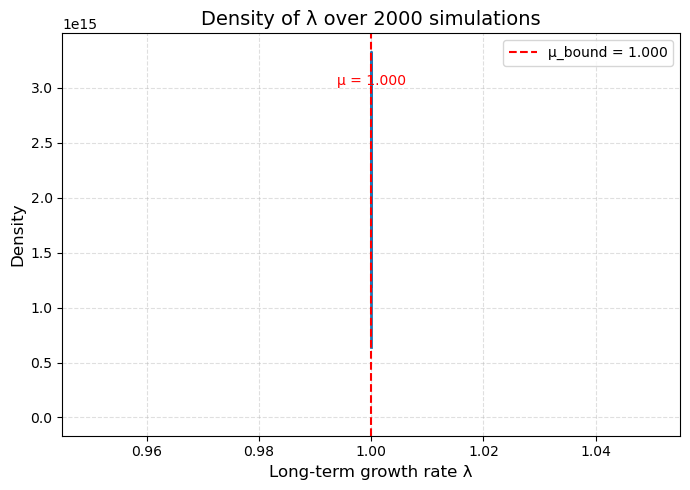

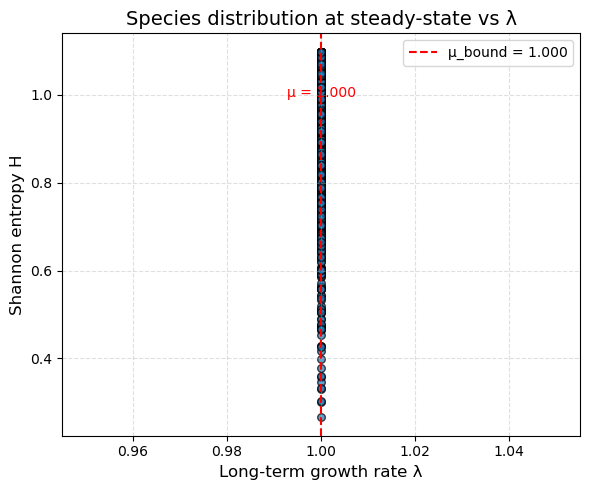

In [58]:
"""
Type 5 growing
"""

N_Y = 3
N_R = 3

S_minus = np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]])

S_plus = np.array([[0, 1, 1],
               [1, 0, 1],
               [1, 1, 0]])
    
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(S_plus, S_minus, N_Y, N_R,
                         n_realizations=2000, dt = 1e-3, n_steps = 250000)